# MSDS_453 Final Project
# Goodreads books review sentimental analysis
# Oliver Petkovski


In [1]:
import re
import os
import sys
import numpy as np
import pandas as pd
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
from string import punctuation
# Import sklearn things
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, \
                                        GRU, Dropout, BatchNormalization, Dense, \
                                        Flatten, GlobalMaxPooling1D, Bidirectional, \
                                        LeakyReLU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adam, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding

In [2]:
import warnings
warnings.filterwarnings('ignore')

****IMPORT DATA*****

In [3]:
#load the data
data = pd.read_csv(r"C:\Users\opw477\OneDrive - Northwestern University\Desktop\MSDS_453\venv4\Final Project Files\CSV\book_reviews_20000.csv")

In [4]:
#data.head()

***EXPLORE/CLEAN DATA***

In [5]:
#remove non-essential columns
data.drop(columns=['book_id', 'user_id', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments'], axis=1, inplace=True)

In [6]:
print(f'Len of dataset: {len(data)}')
data.head()

Len of dataset: 20007


,review_id,rating,review_text
0,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...
1,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...
2,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ..."
3,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...
4,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot..."


In [7]:
# check for missign values
data.isna().sum()

review_id      0
rating         0
review_text    0
dtype: int64

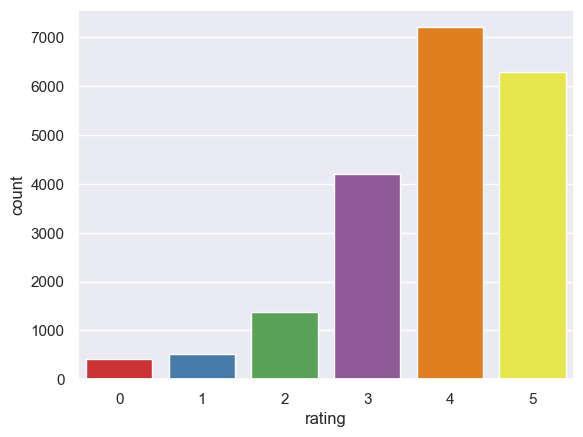

In [8]:
#display distribution of ratings in the data 
sns.set(style="darkgrid")
ax = sns.countplot(x=data['rating'], palette="Set1")

***FUNCTIONS***

In [9]:
# Stopword
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\opw477\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\opw477\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))

In [11]:
#print the stop_words list 
print (stop_words)

{'of', 'his', 'whom', 'over', 'when', 'ain', 'should', 'ma', 'my', 'here', "it's", 'hers', 'll', 'won', 'up', 'your', "don't", 'other', 'wasn', 'wouldn', 'o', 'have', 'them', 'are', 'be', 'this', "aren't", 'now', "you'd", 'some', 'doing', 'd', 'needn', 'for', 'through', 'himself', 'haven', 'which', 'itself', 'such', 'same', 'as', 'herself', 'why', 'had', 'it', 'into', 'doesn', 'while', 'because', "hadn't", 'yourself', 'off', 'nor', 'our', 'is', 'hadn', 'few', 's', 'very', 'couldn', 'that', 'below', 'being', 'who', 'mightn', 'more', 'only', 'weren', "shan't", 'its', 'then', "didn't", 'each', "mustn't", 'will', 'all', 'by', 'on', 'own', 'y', "couldn't", 'hasn', "wasn't", 'from', "wouldn't", 'against', 'do', 'if', 'her', 'these', "that'll", "needn't", 'you', 'a', 'mustn', "you've", 'yours', 'just', 'where', 'after', 'been', 'not', "shouldn't", 'i', 'before', 'down', "weren't", 'than', "mightn't", 'aren', 'most', 'him', 'but', 'don', 'were', 'am', 'out', 'no', 'myself', 'does', 'the', "has

In [12]:
more_stopwords=["spoiler","alert", "book", "read", "one", "get", "cant"]

In [13]:
swl=stopwords.words('english')
swl.extend(more_stopwords)
stop_words = set(swl)
punctuation = list(punctuation)

In [14]:
print (stop_words)

{'get', 'of', 'his', 'whom', 'over', 'when', 'ain', 'should', 'ma', 'my', 'here', "it's", 'hers', 'll', 'won', 'up', 'your', "don't", 'other', 'wasn', 'alert', 'wouldn', 'o', 'have', 'them', 'are', 'be', 'this', "aren't", 'now', "you'd", 'some', 'doing', 'd', 'needn', 'for', 'through', 'himself', 'haven', 'which', 'itself', 'such', 'same', 'as', 'herself', 'why', 'had', 'it', 'into', 'doesn', 'while', 'because', "hadn't", 'yourself', 'off', 'nor', 'cant', 'our', 'is', 'hadn', 'few', 's', 'very', 'couldn', 'that', 'below', 'being', 'who', 'mightn', 'more', 'only', 'weren', "shan't", 'its', 'then', "didn't", 'each', "mustn't", 'will', 'all', 'by', 'on', 'own', 'y', "couldn't", 'hasn', "wasn't", 'from', "wouldn't", 'spoiler', 'against', 'do', 'if', 'her', 'these', "that'll", "needn't", 'you', 'a', 'mustn', "you've", 'yours', 'just', 'where', 'after', 'been', 'one', 'not', "shouldn't", 'i', 'before', 'down', "weren't", 'than', "mightn't", 'aren', 'most', 'him', 'but', 'don', 'were', 'am', 

In [15]:
# Function to clean text
def clean_doc(doc):
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out tokens more than 25 characters long
    tokens = [word for word in tokens if len(word) < 25]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    swl=stopwords.words('english')
    swl.extend(more_stopwords)
    stop_words = set(swl)
    tokens = [w for w in tokens if not w in stop_words]  
    lem = WordNetLemmatizer()
    tokens_lem =[lem.lemmatize(w) for w in tokens]
    #stemmer=PorterStemmer()
    #tokens_stem = [stemmer.stem(w) for w in tokens_lem]
    return tokens_lem

In [16]:
def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

***Execute CLEAN***

In [17]:
#adding two columns to the dataframe to store the processed text and final text
data['processed_text'] = data['review_text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
rev_ids = data['review_id'].tolist()
#ids = data['review_id'].tolist()

processed_text = data['review_text'].tolist()

In [18]:
data['final_text'] = final_processed_text

In [19]:
data.head()

,review_id,rating,review_text,processed_text,final_text
0,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,"[special, started, slow, first, third, middle,...",special started slow first third middle third ...
1,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,"[recommended, katz, avail, free, december]",recommended katz avail free december
2,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...","[fun, fast, paced, science, fiction, thriller,...",fun fast paced science fiction thriller night ...
3,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,"[recommended, reading, understand, going, midd...",recommended reading understand going middle am...
4,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...","[really, enjoyed, lot, recommend, drag, little...",really enjoyed lot recommend drag little end k...


In [20]:
#sample of final processed review 
data['final_text'][100]

'big red star omg funniest absolutely dirtiest book ive ever eve dangerfield fresh unique voice adored story youre stunning said eyeing iris werent watery blue like redhead warm caramel brown ash lady area tingled though craved cigarette thanks keep review clean hard based naughty ashley hardworking nurse worst taste men decides finished boyfriend want baby good sperm donor former model ash party girl always sensitive lowerclass background loser parent raised grandmother sister julia best friend share everything julias boyfriend max gorgeous redheaded roommate named dean big lovable bear man dean coasted life meet ash thats ash feel ginger way wasnt pretty boy nose crooked grin lopsided squarejawed saltoftheearth handsome look made girl think loosehipped cowboy demanding scottish laird speaking scottish laird old mate redhead usually ginger werent scene guy hair rich copperyauburn fox pelt gleamed like rose gold floodlight short beard exact colour stuff head big red big time apparently

***BALANCE the DATA_DOWNSAMPLING****

In [21]:
majority = max(data['rating'].value_counts())
minority = min(data['rating'].value_counts())

In [22]:
print (majority)

7210


In [23]:
print(minority)

423


In [24]:
from sklearn.utils import resample
minority = 423 

df_0 = data[data['rating'] == 0]
df_1 = data[data['rating'] == 1]
df_2 = data[data['rating'] == 2]
df_3 = data[data['rating'] == 3]
df_4 = data[data['rating'] == 4]
df_5 = data[data['rating'] == 5]

# Downsample majority class
df_0_downsampled = resample(df_0, replace=False, n_samples=minority, random_state=44)
df_1_downsampled = resample(df_1, replace=False, n_samples=minority, random_state=44)
df_2_downsampled = resample(df_2, replace=False, n_samples=minority, random_state=44)
df_3_downsampled = resample(df_3, replace=False, n_samples=minority, random_state=44)
df_4_downsampled = resample(df_4, replace=False, n_samples=minority, random_state=44)
df_5_downsampled = resample(df_5, replace=False, n_samples=minority, random_state=44)

# Concatenate the downsampled dataframes
df_downsampled = pd.concat([df_0_downsampled, df_1_downsampled, df_2_downsampled, df_4_downsampled, df_3_downsampled, df_5_downsampled])


In [25]:
df_downsampled.head()

,review_id,rating,review_text,processed_text,final_text
17103,23d89159d1de26d263186fd5aca842a4,0,Loved this book!,[loved],loved
9895,899b5f1107e7afcd6d73e93256f8a1f4,0,"I read this for high school and, I confess, no...","[high, school, confess, since, ill, remedy, soon]",high school confess since ill remedy soon
7197,fac0cec5db9241238507d9bdd66e2821,0,See review on Guardians of the West for my rev...,"[see, review, guardian, west, review, series]",see review guardian west review series
4626,30fa9e694b94f1764edcc07822f4ff4e,0,Dnf at 25% \n June 2017,"[dnf, june]",dnf june
17502,6000837889d0f16220a2d231c77c3044,0,I really want to get to the part where she'll ...,"[really, want, part, shell, meet, love, intere...",really want part shell meet love interest read...


In [26]:
print(f'Len of dataset: {len(df_downsampled)}')

Len of dataset: 2538


In [27]:
del [df_0_downsampled, df_1_downsampled, df_2_downsampled, df_4_downsampled, df_3_downsampled, df_5_downsampled]

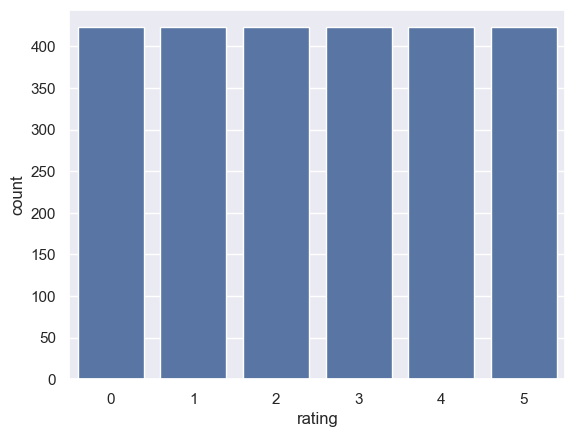

In [28]:
# Display the count of each type of rating after balancing
sns.countplot(x=df_downsampled['rating']);

# ORIGINAL DATA

In [29]:
#Original Data
df = data
docs = final_processed_text

In [30]:
len(docs)

20007

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df, df['rating'], test_size=0.4, stratify=df['rating'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=X_temp['rating'], random_state=42)

# Assign names to the splits
train = X_train
val = X_val
test = X_test
rf_train = X_temp  # rf_train will contain the remaining data after creating train, val, and test sets

# Check the lengths of the splits
len(train), len(val), len(test), len(rf_train)



(12004, 4001, 4002, 8003)

In [32]:
# Document sets corresponding to the splits
train_docs = [docs[i] for i in X_train.index]
rf_train_docs = [docs[i] for i in rf_train.index]
val_docs = [docs[i] for i in X_val.index]
test_docs = [docs[i] for i in X_test.index]


In [33]:
#length of the train doc 
len(train_docs), len(val_docs), len(test_docs), len(rf_train_docs)

(12004, 4001, 4002, 8003)

In [34]:
train.rating.value_counts()

4    4326
5    3776
3    2523
2     820
1     305
0     254
Name: rating, dtype: int64

****TFIDF 2gram, max features 100****

In [35]:
#TF-IDF
tfidf100 = TfidfVectorizer(ngram_range=(1, 2),
                                max_features=100)
tfidf100_train_matrix = tfidf100.fit_transform(train_docs).toarray()
tfidf100_val_matrix = tfidf100.transform(val_docs).toarray()
tfidf100_test_matrix = tfidf100.transform(test_docs).toarray()

rf_tfidf100_train = tfidf100.fit_transform(rf_train_docs).toarray()
rf_tfidf100_test = tfidf100.transform(test_docs).toarray()

In [36]:
#ensure current dir is the venv4 env and open a file in the dir for the arrays
import os
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: C:\Users\opw477\OneDrive - Northwestern University\Desktop\MSDS_453\venv4


In [37]:
# Export tfidf arrays for modeling
np.save('embeddings_arrays/tfidf100_train.npy', tfidf100_train_matrix)
np.save('embeddings_arrays/tfidf100_val.npy', tfidf100_val_matrix)
np.save('embeddings_arrays/tfidf100_test.npy', tfidf100_test_matrix)
np.save('embeddings_arrays/tfidf100_rf_train.npy', rf_tfidf100_train)

In [38]:
# Print the terms and their corresponding TF-IDF values
feature_names = np.array(tfidf100.get_feature_names_out())
total_tfidf_scores = np.sum(tfidf100_train_matrix, axis=0)
sorted_indices = np.argsort(total_tfidf_scores)[::-1]
# Get the first 10 indices
top_indices = sorted_indices[:20]
for index in top_indices:
    term = feature_names[index]
    tfidf_value = total_tfidf_scores[index]
    print(f'Term: {term}, TF-IDF: {tfidf_value}')


Term: start, TF-IDF: 1089.2627201597163
Term: quite, TF-IDF: 940.9055980966338
Term: character, TF-IDF: 936.3525479984256
Term: life, TF-IDF: 892.0114198958757
Term: live, TF-IDF: 870.1028510436439
Term: thought, TF-IDF: 705.0451141764487
Term: say, TF-IDF: 701.2500853698534
Term: good, TF-IDF: 635.3496486762509
Term: man, TF-IDF: 611.3883324483114
Term: lot, TF-IDF: 607.3763517151642
Term: definitely, TF-IDF: 588.2059310478629
Term: first, TF-IDF: 578.4899209391856
Term: would, TF-IDF: 570.0238833776929
Term: book, TF-IDF: 550.6598906468464
Term: really, TF-IDF: 543.3815271730242
Term: take, TF-IDF: 539.4560729979441
Term: shes, TF-IDF: 526.6094286538313
Term: plot, TF-IDF: 518.8809988655727
Term: way, TF-IDF: 514.4217955277517
Term: kind, TF-IDF: 506.1455518128287


********GloVe*********

In [39]:
glove50_path =  r'C:\Users\opw477\OneDrive - Northwestern University\Desktop\MSDS_453\venv4\Final Project Files\Glove\glove.6B.50d.txt'
glove100_path =  r'C:\Users\opw477\OneDrive - Northwestern University\Desktop\MSDS_453\venv4\Final Project Files\Glove\glove.6B.100d.txt'
glove200_path =  r'C:\Users\opw477\OneDrive - Northwestern University\Desktop\MSDS_453\venv4\Final Project Files\Glove\glove.6B.200d.txt'

In [40]:
ndim = 100
glove100_embeddings_index = {}

with open(glove100_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        ps = PorterStemmer()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove100_embeddings_index[word] = coefs

print('Found %s word vectors.' % len(glove100_embeddings_index))



Found 400000 word vectors.


In [41]:
word_count = lambda sentence: len(word_tokenize(sentence))
length_long_sentence = len(max(train_docs, key=word_count))


In [42]:
# Initialize the tokenizer first
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs)

# Get the word index
word_index = tokenizer.word_index

# Check the vocabulary size
vocabulary_size = len(word_index)
print("Vocabulary Size:", vocabulary_size)


Vocabulary Size: 42160


In [43]:
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(train_docs)
sequences = tokenizer.texts_to_sequences(train_docs)
glove100_train = pad_sequences(sequences, length_long_sentence)
word_index = tokenizer.word_index
len(word_index)

glove100_test = tokenizer.texts_to_sequences(test_docs)
glove100_test = np.asarray(pad_sequences(glove100_test, length_long_sentence))
glove100_val = tokenizer.texts_to_sequences(val_docs)
glove100_val = np.asarray(pad_sequences(glove100_val, length_long_sentence))

In [44]:
# Creates labels
train_labels = np.asarray(train.rating)
val_labels = np.asarray(val.rating)
test_labels = np.asarray(test.rating)
rf_train_labels = np.asarray(rf_train.rating)

# Convert to one-hot encoding 
train_labels = to_categorical(train_labels, num_classes=6)
glove_val_labels = to_categorical(val_labels, num_classes=6)
glove_test_labels = to_categorical(test_labels, num_classes=6)
rf_train_labels = to_categorical(rf_train_labels, num_classes=6)

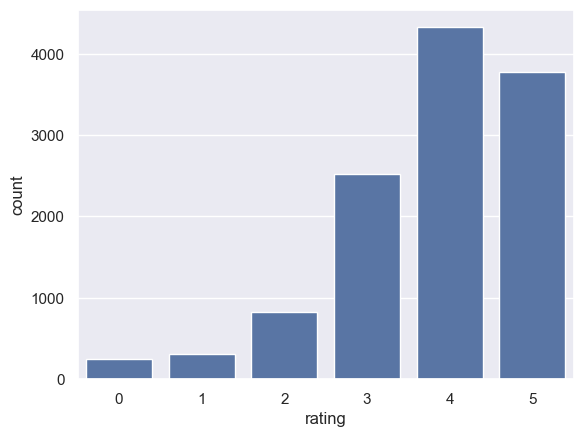

In [45]:
sns.countplot(x=train['rating']);

In [46]:
print(np.unique(test_labels))
print(np.unique(train_labels))
print(np.unique(val_labels))

[0 1 2 3 4 5]
[0. 1.]
[0 1 2 3 4 5]


In [47]:
glove100_train.shape, glove100_val.shape, train_labels.shape, glove_val_labels.shape, glove_test_labels.shape

((12004, 7571), (4001, 7571), (12004, 6), (4001, 6), (4002, 6))

In [48]:
# Save labels
np.save('embeddings_arrays/train_labels.npy', train_labels)
np.save('embeddings_arrays/val_labels.npy', val_labels)
np.save('embeddings_arrays/test_labels.npy', test_labels)

In [49]:
glove100_embedding_matrix = np.zeros((len(word_index) + 1, ndim))
for word, i in word_index.items():
    embedding_vector = glove100_embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        glove100_embedding_matrix[i] = embedding_vector

In [50]:
from tensorflow.keras.layers import Embedding
glove100_embedding_layer = Embedding(len(word_index) + 1, # input len(embedding array)
                            100,
                            weights=[glove100_embedding_matrix],
                            input_length=length_long_sentence,
                            trainable=False)

In [51]:
sequence100_input = Input(shape=(100,), dtype='int32')
glove100embedded_sequences = glove100_embedding_layer(sequence100_input)

In [52]:
# Export weights
np.save('embeddings_arrays/glove100_weights.npy', glove100_embedding_matrix)

#MODELS

In [53]:
# models f1's
classifier_results = list()

#RANDOM FOREST

In [54]:
rf_train_labels = np.asarray(rf_train.rating)
rf_test_labels = np.asarray(test.rating)
seed = 42

In [55]:
#Classifier
data = dict()
rfc = RandomForestClassifier(random_state=seed, n_estimators=100)
rfr = RandomForestRegressor(random_state=seed, n_estimators=100)

In [56]:
cv_scores = cross_val_score(rfc, rf_tfidf100_train, 
                    rf_train_labels, cv=5, scoring='f1_macro', 
                    n_jobs=-1)

In [57]:
# Fit the classifier with training data
rfc.fit(rf_tfidf100_train, rf_train_labels)

RandomForestClassifier(random_state=42)

In [58]:
rfc_train_preds = rfc.predict(rf_tfidf100_train)
rfc_preds = rfc.predict(tfidf100_test_matrix)

In [59]:
print(np.unique(test_labels))


[0 1 2 3 4 5]


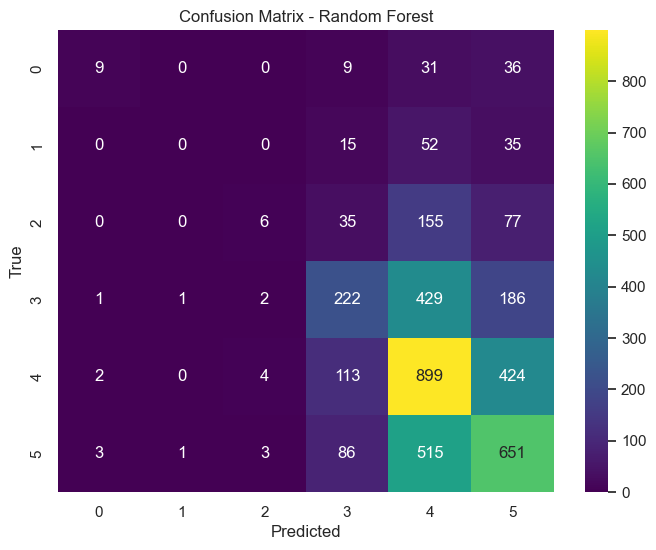

{'model': 'RF TF-IDF', 'train_f1': 0.941, 'val_f1': 0.226, 'test_f1': 0.259}

In [60]:
# Visualize confusion matrix and print F1's
data['model'] = 'RF TF-IDF'
data['train_f1'] = round(f1_score(rfc_train_preds, rf_train_labels, average='macro'), 3)
data['val_f1'] = round(np.mean(cv_scores), 3)
data['test_f1'] = round(f1_score(rfc_preds, test_labels, average='macro'), 3)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, rfc_preds)
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classifier_results.append(data)
data

###DENSE NEURAL NETWORK 

In [61]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)
model = Sequential([
    sequence100_input,
    glove100_embedding_layer,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation = 'softmax')
])

model.summary()
opt = 'rmsprop'
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  4216100   
                                                                 
 flatten (Flatten)           (None, 757100)            0         
                                                                 
 dense (Dense)               (None, 128)               96908928  
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 101125802 (385.76 MB)
Trainable params: 96909702 (369.68 MB)
Non-trainable params: 4216100 (16.08 MB)
_________________________________________________________________


In [62]:
data = dict()
model.fit(glove100_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 10,
            batch_size=32)

Epoch 1/10
376/376 [==============================] - 195s 517ms/step - loss: 1.4511 - accuracy: 0.3807 - val_loss: 1.3510 - val_accuracy: 0.4164
Epoch 2/10
376/376 [==============================] - 184s 491ms/step - loss: 1.1802 - accuracy: 0.5019 - val_loss: 1.4386 - val_accuracy: 0.4111
Epoch 3/10
376/376 [==============================] - 184s 491ms/step - loss: 0.9312 - accuracy: 0.6210 - val_loss: 1.6718 - val_accuracy: 0.4009
Epoch 4/10
376/376 [==============================] - 187s 498ms/step - loss: 0.7053 - accuracy: 0.7201 - val_loss: 1.7537 - val_accuracy: 0.4046
Epoch 5/10
376/376 [==============================] - 184s 489ms/step - loss: 0.5079 - accuracy: 0.8091 - val_loss: 2.3558 - val_accuracy: 0.3847
Epoch 6/10
376/376 [==============================] - 186s 496ms/step - loss: 0.3548 - accuracy: 0.8769 - val_loss: 2.2116 - val_accuracy: 0.3952
Epoch 7/10
376/376 [==============================] - 185s 491ms/step - loss: 0.2411 - accuracy: 0.9218 - val_loss: 2.5503 -

In [63]:
test_loss, test_acc = model.evaluate(np.asarray(glove100_test), glove_test_labels)
test_loss, test_acc

126/126 [==============================] - 7s 57ms/step - loss: 3.6645 - accuracy: 0.3783


(3.6645216941833496, 0.3783108592033386)

In [64]:
train_labels[0]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [65]:
# Generate train F1 score
train_preds = model.predict(glove100_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
dnn_preds = model.predict(glove100_test)
test_f1 = f1_score(np.argmax(dnn_preds, axis=1), test_labels, average='macro')



126/126 [==============================] - 7s 59ms/step


In [66]:
data['model'] = 'DNN- GloVe'
data['train_f1'] = round(train_f1, 3)
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data

{'model': 'DNN- GloVe', 'train_f1': 0.978, 'test_f1': 0.247}

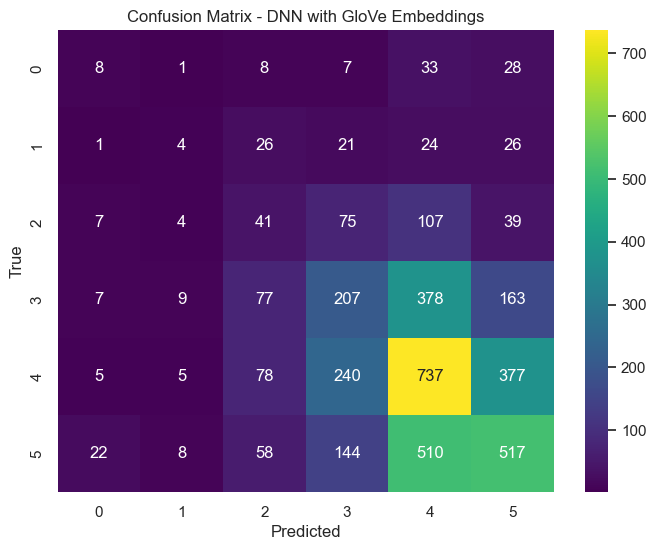

In [67]:
# Generate predictions on the test set
predicted_labels = np.argmax(dnn_preds, axis=1)
# Create the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - DNN with GloVe Embeddings')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



#DNN TF-IDF 

In [68]:
model = Sequential([
    Dense(32, input_shape=(100,)),
    Dense(128, activation='relu'),
    Dense(6, activation = 'softmax')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                3232      
                                                                 
 dense_3 (Dense)             (None, 128)               4224      
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
Total params: 8230 (32.15 KB)
Trainable params: 8230 (32.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
model.fit(tfidf100_train_matrix, train_labels,
            epochs=15,
            batch_size=32)

Epoch 1/15
376/376 [==============================] - 1s 994us/step - loss: 1.3548 - accuracy: 0.4070
Epoch 2/15
376/376 [==============================] - 0s 905us/step - loss: 1.2601 - accuracy: 0.4538
Epoch 3/15
376/376 [==============================] - 0s 1ms/step - loss: 1.2459 - accuracy: 0.4573
Epoch 4/15
376/376 [==============================] - 0s 876us/step - loss: 1.2370 - accuracy: 0.4618
Epoch 5/15
376/376 [==============================] - 0s 885us/step - loss: 1.2318 - accuracy: 0.4668
Epoch 6/15
376/376 [==============================] - 0s 1ms/step - loss: 1.2261 - accuracy: 0.4688
Epoch 7/15
376/376 [==============================] - 0s 855us/step - loss: 1.2206 - accuracy: 0.4724
Epoch 8/15
376/376 [==============================] - 0s 844us/step - loss: 1.2148 - accuracy: 0.4758
Epoch 9/15
376/376 [==============================] - 0s 1ms/step - loss: 1.2087 - accuracy: 0.4763
Epoch 10/15
376/376 [==============================] - 0s 858us/step - loss: 1.2033 - ac

In [70]:
# Train the model
model.fit(tfidf100_train_matrix, train_labels, epochs=15, batch_size=32)

# Generate train F1 score
train_preds_tfidf = model.predict(tfidf100_train_matrix)
train_f1_tfidf = f1_score(np.argmax(train_preds_tfidf, axis=1), np.argmax(train_labels, axis=1), average='macro')

# Generate test F1 score
test_preds_tfidf = model.predict(tfidf100_test_matrix)
test_f1_tfidf = f1_score(np.argmax(test_preds_tfidf, axis=1), test_labels, average='macro')

# Print or use the results as needed
print("Train F1 Score (TF-IDF):", train_f1_tfidf)
print("Test F1 Score (TF-IDF):", test_f1_tfidf)

# Add the results to classifier_results for TF-IDF
data_tfidf = {
    'model': 'DNN- TF-IDF',
    'train_f1': round(train_f1_tfidf, 3),
    'test_f1': round(test_f1_tfidf, 3)
}

# Append the new results to classifier_results
classifier_results.append(data_tfidf)


Epoch 1/15
376/376 [==============================] - 0s 875us/step - loss: 1.1662 - accuracy: 0.5060
Epoch 2/15
376/376 [==============================] - 0s 969us/step - loss: 1.1602 - accuracy: 0.5063
Epoch 3/15
376/376 [==============================] - 0s 913us/step - loss: 1.1535 - accuracy: 0.5127
Epoch 4/15
376/376 [==============================] - 0s 903us/step - loss: 1.1473 - accuracy: 0.5127
Epoch 5/15
376/376 [==============================] - 0s 995us/step - loss: 1.1395 - accuracy: 0.5142
Epoch 6/15
376/376 [==============================] - 0s 878us/step - loss: 1.1334 - accuracy: 0.5177
Epoch 7/15
376/376 [==============================] - 0s 855us/step - loss: 1.1278 - accuracy: 0.5270
Epoch 8/15
376/376 [==============================] - 0s 1ms/step - loss: 1.1216 - accuracy: 0.5280
Epoch 9/15
376/376 [==============================] - 0s 854us/step - loss: 1.1150 - accuracy: 0.5346
Epoch 10/15
376/376 [==============================] - 0s 851us/step - loss: 1.1087 

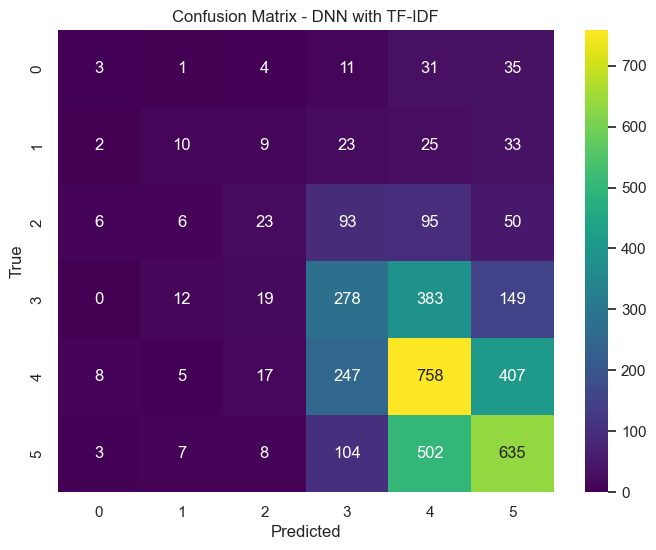

In [71]:
# Generate predictions on the test set for the new model
predicted_labels_tfidf = np.argmax(test_preds_tfidf, axis=1)

# Create the confusion matrix for the new model
conf_matrix_tfidf = confusion_matrix(test_labels, predicted_labels_tfidf)

# Visualize the confusion matrix for the new model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tfidf, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - DNN with TF-IDF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#CNN_GloVe

In [72]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)

model = Sequential([
    glove100_embedding_layer,
    Conv1D(128, 3),
    LeakyReLU(),
    MaxPooling1D(3),
    BatchNormalization(),
    Conv1D(128, 3),
    LeakyReLU(),
    MaxPooling1D(3),
    BatchNormalization(),
    #GlobalMaxPooling1D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.summary()
opt = SGD(lr=0.001)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics = ['acc']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  4216100   
                                                                 
 conv1d (Conv1D)             (None, 7569, 128)         38528     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7569, 128)         0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 2523, 128)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 2523, 128)         512       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 2521, 128)        

In [73]:
model.fit(glove100_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 15,
            batch_size=100)

Epoch 1/15
121/121 [==============================] - 238s 2s/step - loss: 2.4647 - acc: 0.3352 - val_loss: 1.6560 - val_acc: 0.3144
Epoch 2/15
121/121 [==============================] - 251s 2s/step - loss: 1.4381 - acc: 0.3530 - val_loss: 1.7477 - val_acc: 0.3619
Epoch 3/15
121/121 [==============================] - 271s 2s/step - loss: 1.4666 - acc: 0.3565 - val_loss: 1.4753 - val_acc: 0.3694
Epoch 4/15
121/121 [==============================] - 246s 2s/step - loss: 1.4134 - acc: 0.3642 - val_loss: 1.6542 - val_acc: 0.3627
Epoch 5/15
121/121 [==============================] - 254s 2s/step - loss: 1.4036 - acc: 0.3642 - val_loss: 1.4026 - val_acc: 0.3634
Epoch 6/15
121/121 [==============================] - 262s 2s/step - loss: 1.3761 - acc: 0.3750 - val_loss: 1.8530 - val_acc: 0.3529
Epoch 7/15
121/121 [==============================] - 273s 2s/step - loss: 1.3999 - acc: 0.3759 - val_loss: 1.8359 - val_acc: 0.3787
Epoch 8/15
121/121 [==============================] - 255s 2s/step - 

In [74]:
# Generate train F1 score
train_preds = model.predict(glove100_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
preds = model.predict(glove100_test)
cnn_preds = model.predict(glove100_test)
test_f1 = f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

126/126 [==============================] - 21s 163ms/step


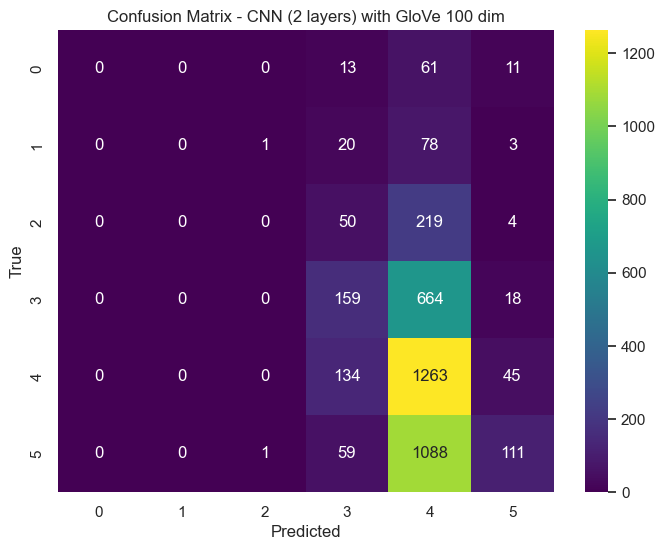

In [75]:
# Confusion matrix for test data
conf_matrix = confusion_matrix(test_labels, np.argmax(preds, axis=1))

# Plot confusion matrix with the same style as the previous one
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - CNN (2 layers) with GloVe 100 dim')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [76]:
# Update the data dictionary with the F1 scores
data = dict()
data['model'] = 'CNN- GloVe'
data['train_f1'] = round(train_f1, 3)
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data

{'model': 'CNN- GloVe', 'train_f1': 0.183, 'test_f1': 0.154}

In [77]:
pd.DataFrame(classifier_results)

,model,train_f1,val_f1,test_f1
0,RF TF-IDF,0.941,0.226,0.259
1,DNN- GloVe,0.978,NaN,0.247
2,DNN- TF-IDF,0.440,NaN,0.273
3,CNN- GloVe,0.183,NaN,0.154


# Balanced Data

In [78]:
#UPSAMPLED DATA
# Reset indices
df_downsampled.reset_index(drop=True, inplace=True)

In [79]:
df_up =  df_downsampled
docs_up = df_downsampled['final_text'].tolist()

In [82]:
# #UPSAMPLED DATA
# df_up = df_upsampled
# docs_up = df_upsampled['final_text'].tolist()

# Split the upsampled data
X_train_up, X_temp_up, y_train_up, y_temp_up = train_test_split(df_up, df_up['rating'], test_size=0.4, stratify=df_up['rating'], random_state=42)
X_val_up, X_test_up, y_val_up, y_test_up = train_test_split(X_temp_up, y_temp_up, test_size=0.5, stratify=X_temp_up['rating'], random_state=42)

# Assign names to the upsampled splits
train_up = X_train_up
val_up = X_val_up
test_up = X_test_up
rf_train_up = X_temp_up  # rf_train_up will contain the remaining data after creating train, val, and test sets

# Check the lengths of the upsampled splits
len(train_up), len(val_up), len(test_up), len(rf_train_up)


(1522, 508, 508, 1016)

In [83]:
# Document sets corresponding to the upsampled splits
train_docs_up = [docs_up[i] for i in X_train_up.index]
rf_train_docs_up = [docs_up[i] for i in rf_train_up.index]
val_docs_up = [docs_up[i] for i in X_val_up.index]
test_docs_up = [docs_up[i] for i in X_test_up.index]


In [84]:
# Length of the upsampled train docs
len(train_docs_up), len(val_docs_up), len(test_docs_up), len(rf_train_docs_up)

(1522, 508, 508, 1016)

In [85]:
train_up.rating.value_counts()

1    254
2    254
0    254
5    254
4    253
3    253
Name: rating, dtype: int64

TF-IDF_Balanced Data

In [86]:
# TF-IDF for upsampled data
tfidf100_up = TfidfVectorizer(ngram_range=(1, 2),
                              max_features=100)

tfidf100_train_up_matrix = tfidf100_up.fit_transform(train_docs_up).toarray()
tfidf100_val_up_matrix = tfidf100_up.transform(val_docs_up).toarray()
tfidf100_test_up_matrix = tfidf100_up.transform(test_docs_up).toarray()

rf_tfidf100_train_up = tfidf100_up.fit_transform(rf_train_docs_up).toarray()
rf_tfidf100_test_up = tfidf100_up.transform(test_docs_up).toarray()


In [87]:
# Export tfidf arrays for modeling on upsampled data
np.save('embeddings_arrays/tfidf100_train_up.npy', tfidf100_train_up_matrix)
np.save('embeddings_arrays/tfidf100_val_up.npy', tfidf100_val_up_matrix)
np.save('embeddings_arrays/tfidf100_test_up.npy', tfidf100_test_up_matrix)
np.save('embeddings_arrays/tfidf100_rf_train_up.npy', rf_tfidf100_train_up)

Glove_Balanced

In [88]:
# Load GloVe embeddings with 100 dimensions for upsampled data
ndim = 100
glove100_embeddings_index_up = {}

with open(glove100_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        ps = PorterStemmer()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove100_embeddings_index_up[word] = coefs

print('Found %s word vectors.' % len(glove100_embeddings_index_up))

Found 400000 word vectors.


In [89]:
word_count_up = lambda sentence: len(word_tokenize(sentence))
length_long_sentence_up = len(max(train_docs_up, key=word_count_up))

In [90]:
# Initialize the tokenizer for upsampled data
tokenizer_up = Tokenizer()
tokenizer_up.fit_on_texts(train_docs_up)

# Get the word index for upsampled data
word_index_up = tokenizer_up.word_index

# Check the vocabulary size for upsampled data
vocabulary_size_up = len(word_index_up)
print("Vocabulary Size:", vocabulary_size_up)


Vocabulary Size: 13620


In [91]:
# Reinitialize the tokenizer for upsampled data
tokenizer_up = Tokenizer(num_words=1000)
tokenizer_up.fit_on_texts(train_docs_up)
sequences_up = tokenizer_up.texts_to_sequences(train_docs_up)
glove100_train_up = pad_sequences(sequences_up, length_long_sentence_up)
word_index_up = tokenizer_up.word_index
len(word_index_up)

glove100_test_up = tokenizer_up.texts_to_sequences(test_docs_up)
glove100_test_up = np.asarray(pad_sequences(glove100_test_up, length_long_sentence_up))
glove100_val_up = tokenizer_up.texts_to_sequences(val_docs_up)
glove100_val_up = np.asarray(pad_sequences(glove100_val_up, length_long_sentence_up))


In [92]:
# Creates labels for upsampled data
train_labels_up = np.asarray(train_up['rating'])
val_labels_up = np.asarray(val_up['rating'])
test_labels_up = np.asarray(test_up['rating'])
rf_train_labels_up = np.asarray(rf_train_up['rating'])

# Convert to one-hot encoding for upsampled data
train_labels_up = to_categorical(train_labels_up, num_classes=6)
glove_val_labels_up = to_categorical(val_labels_up, num_classes=6)
glove_test_labels_up = to_categorical(test_labels_up, num_classes=6)
rf_train_labels_up = to_categorical(rf_train_labels_up, num_classes=6)


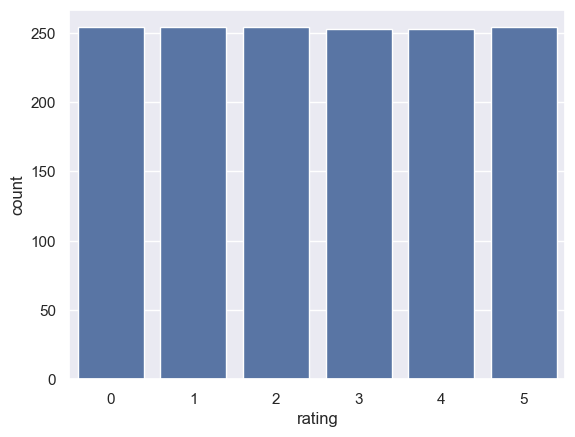

In [93]:
sns.countplot(x=train_up['rating']);


In [94]:
print(np.unique(test_labels_up))
print(np.unique(train_labels_up))
print(np.unique(val_labels_up))

[0 1 2 3 4 5]
[0. 1.]
[0 1 2 3 4 5]


In [95]:
glove100_train_up.shape, glove100_val_up.shape, train_labels_up.shape, glove_val_labels_up.shape, glove_test_labels_up.shape

((1522, 7223), (508, 7223), (1522, 6), (508, 6), (508, 6))

In [96]:
# Save labels for the upsampled data
np.save('embeddings_arrays/train_labels_up.npy', train_labels_up)
np.save('embeddings_arrays/val_labels_up.npy', val_labels_up)
np.save('embeddings_arrays/test_labels_up.npy', test_labels_up)

In [97]:
# Initialize the embedding matrix for the upsampled data
glove100_embedding_matrix_up = np.zeros((len(word_index_up) + 1, ndim))
for word, i in word_index_up.items():
    embedding_vector = glove100_embeddings_index_up.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all-zeros
        glove100_embedding_matrix_up[i] = embedding_vector

In [98]:
from tensorflow.keras.layers import Embedding
glove100_embedding_layer_up = Embedding(
    len(word_index_up) + 1,  # input len(embedding array)
    100,
    weights=[glove100_embedding_matrix_up],
    input_length=length_long_sentence_up,
    trainable=False
)

In [99]:
sequence100_input_up = Input(shape=(100,), dtype='int32')
glove100embedded_sequences_up = glove100_embedding_layer_up(sequence100_input_up)

In [100]:
# Export weights for the upsampled data
np.save('embeddings_arrays/glove100_weights_up.npy', glove100_embedding_matrix_up)

Random Forest_Balanced Data

In [101]:
rf_train_labels_up = np.asarray(rf_train_up.rating)
rf_test_labels_up = np.asarray(test_up.rating)
seed = 42

In [102]:
data_up = dict()
rfc_up = RandomForestClassifier(random_state=seed, n_estimators=100)
rfr_up = RandomForestRegressor(random_state=seed, n_estimators=100)

In [103]:
cv_scores_up = cross_val_score(rfc_up, rf_tfidf100_train_up, 
                               rf_train_labels_up, cv=5, 
                               scoring='f1_macro', n_jobs=-1)

In [104]:
# Fit the classifier with training data for upsampled data
rfc_up.fit(rf_tfidf100_train_up, rf_train_labels_up)

RandomForestClassifier(random_state=42)

In [105]:
# Predictions for the upsampled data
rfc_train_preds_up = rfc_up.predict(rf_tfidf100_train_up)
rfc_preds_up = rfc_up.predict(rf_tfidf100_test_up)

In [106]:
print(np.unique(test_labels_up))

[0 1 2 3 4 5]


In [107]:
data_up['model'] = 'RF TF-IDF Balanced'
# Calculate F1 scores for upsampled data
data_up['train_f1'] = round(f1_score(rfc_train_preds_up, rf_train_labels_up, average='macro'), 3)
data_up['val_f1'] = round(np.mean(cv_scores_up), 3)
data_up['test_f1'] = round(f1_score(rfc_preds_up, rf_test_labels_up, average='macro'), 3)

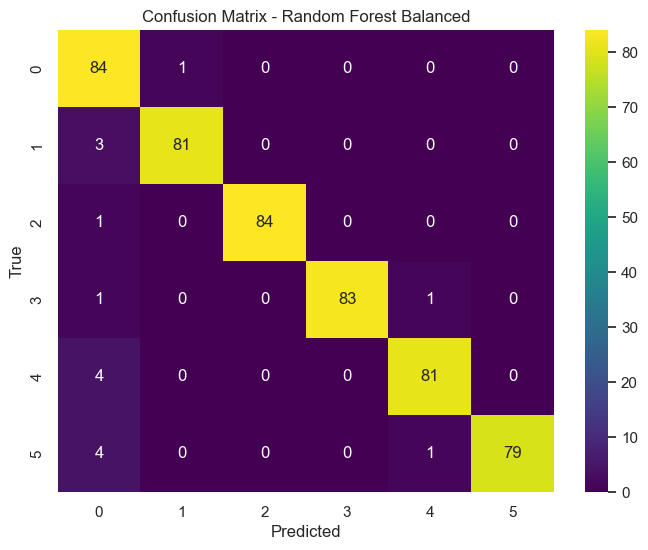

{'model': 'RF TF-IDF Balanced',
 'train_f1': 0.97,
 'val_f1': 0.336,
 'test_f1': 0.969}

In [108]:
# Calculate confusion matrix for upsampled data
conf_matrix_up = confusion_matrix(rf_test_labels_up, rfc_preds_up)

# Visualize the confusion matrix for upsampled data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_up, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - Random Forest Balanced')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Append results for upsampled data to the classifier_results list
classifier_results.append(data_up)
data_up

DNN_GLOVE_Balanced

In [109]:
sequence100_input_up = Input(shape=(length_long_sentence_up,), dtype='int32')
glove100_embedded_sequences_up = glove100_embedding_layer(sequence100_input_up)
model_up = Sequential([
    sequence100_input_up,
    glove100_embedding_layer,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

model_up.summary()
opt = 'rmsprop'
model_up.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  4216100   
                                                                 
 flatten_2 (Flatten)         (None, 722300)            0         
                                                                 
 dense_7 (Dense)             (None, 128)               92454528  
                                                                 
 dense_8 (Dense)             (None, 6)                 774       
                                                                 
Total params: 96671402 (368.77 MB)
Trainable params: 92455302 (352.69 MB)
Non-trainable params: 4216100 (16.08 MB)
_________________________________________________________________


In [110]:
data_up = dict()
model_up.fit(glove100_train_up, train_labels_up,
             validation_data=(glove100_val_up, glove_val_labels_up),
             epochs=10,
             batch_size=32)

Epoch 1/10
48/48 [==============================] - 21s 430ms/step - loss: 1.9099 - accuracy: 0.2326 - val_loss: 1.7514 - val_accuracy: 0.2382
Epoch 2/10
48/48 [==============================] - 31s 643ms/step - loss: 1.6510 - accuracy: 0.3246 - val_loss: 1.7984 - val_accuracy: 0.2677
Epoch 3/10
48/48 [==============================] - 23s 469ms/step - loss: 1.2296 - accuracy: 0.5420 - val_loss: 1.9459 - val_accuracy: 0.2520
Epoch 4/10
48/48 [==============================] - 23s 471ms/step - loss: 0.7634 - accuracy: 0.7733 - val_loss: 2.0745 - val_accuracy: 0.2638
Epoch 5/10
48/48 [==============================] - 23s 482ms/step - loss: 0.4830 - accuracy: 0.8758 - val_loss: 2.5381 - val_accuracy: 0.2559
Epoch 6/10
48/48 [==============================] - 23s 480ms/step - loss: 0.3158 - accuracy: 0.9192 - val_loss: 2.4015 - val_accuracy: 0.2146
Epoch 7/10
48/48 [==============================] - 25s 512ms/step - loss: 0.2160 - accuracy: 0.9534 - val_loss: 2.6071 - val_accuracy: 0.2441

In [111]:
test_loss_up, test_acc_up = model_up.evaluate(np.asarray(glove100_test_up), glove_test_labels_up)
test_loss_up, test_acc_up

16/16 [==============================] - 1s 67ms/step - loss: 3.1634 - accuracy: 0.2362


(3.1634249687194824, 0.23622047901153564)

In [112]:
train_labels_up[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

In [113]:
# Generate train F1 score for upsampled data
train_preds_up = model_up.predict(glove100_train_up)
train_f1_up = f1_score(np.argmax(train_preds_up, axis=1), 
                       np.argmax(train_labels_up, axis=1), 
                       average='macro')

# Generate test F1 score for upsampled data                    
dnn_preds_up = model_up.predict(glove100_test_up)
test_f1_up = f1_score(np.argmax(dnn_preds_up, axis=1), 
                      rf_test_labels_up, average='macro')

16/16 [==============================] - 1s 62ms/step


In [114]:
# Update the model name and F1 scores for upsampled data
data_up['model'] = 'DNN-GloVe_Balanced'
data_up['train_f1'] = round(train_f1_up, 3)
data_up['test_f1'] = round(test_f1_up, 3)

# Append results for upsampled data to the classifier_results list
classifier_results.append(data_up)
data_up

{'model': 'DNN-GloVe_Balanced', 'train_f1': 0.99, 'test_f1': 0.232}

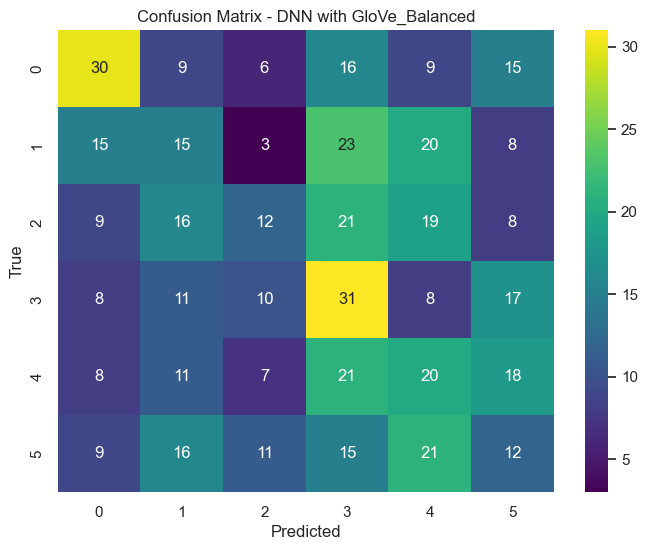

In [115]:
# Generate predictions on the upsampled test set
predicted_labels_up = np.argmax(dnn_preds_up, axis=1)

# Create the confusion matrix for upsampled data
conf_matrix_up = confusion_matrix(np.argmax(glove_test_labels_up, axis=1), predicted_labels_up)

# Visualize the confusion matrix for upsampled data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_up, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - DNN with GloVe_Balanced')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
DNN-TFIDF_Balanced data 

In [117]:
# Define the model
model_balanced = Sequential([
    Dense(32, input_shape=(tfidf100_train_up_matrix.shape[1],), activation='relu'),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

In [118]:
# Display the model summary
model_balanced.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                3232      
                                                                 
 dense_10 (Dense)            (None, 128)               4224      
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                                 
Total params: 8230 (32.15 KB)
Trainable params: 8230 (32.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
# Compile the model
opt = 'rmsprop'
model_balanced.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [120]:
# Train the model on the balanced TF-IDF data
model_balanced.fit(tfidf100_train_up_matrix, train_labels_up,
                   epochs=15,
                   batch_size=32)

Epoch 1/15
48/48 [==============================] - 0s 853us/step - loss: 1.7895 - accuracy: 0.1827
Epoch 2/15
48/48 [==============================] - 0s 842us/step - loss: 1.7697 - accuracy: 0.2602
Epoch 3/15
48/48 [==============================] - 0s 776us/step - loss: 1.7376 - accuracy: 0.3022
Epoch 4/15
48/48 [==============================] - 0s 827us/step - loss: 1.6868 - accuracy: 0.3384
Epoch 5/15
48/48 [==============================] - 0s 810us/step - loss: 1.6250 - accuracy: 0.3778
Epoch 6/15
48/48 [==============================] - 0s 767us/step - loss: 1.5704 - accuracy: 0.3883
Epoch 7/15
48/48 [==============================] - 0s 764us/step - loss: 1.5268 - accuracy: 0.4060
Epoch 8/15
48/48 [==============================] - 0s 836us/step - loss: 1.4957 - accuracy: 0.4126
Epoch 9/15
48/48 [==============================] - 0s 793us/step - loss: 1.4705 - accuracy: 0.4152
Epoch 10/15
48/48 [==============================] - 0s 789us/step - loss: 1.4498 - accuracy: 0.4317

In [121]:
# Generate train F1 score
train_preds_tfidf_balanced = model_balanced.predict(tfidf100_train_up_matrix)
train_f1_tfidf_balanced = f1_score(np.argmax(train_preds_tfidf_balanced, axis=1), np.argmax(train_labels_up, axis=1), average='macro')

# Generate test F1 score
test_preds_tfidf_balanced = model_balanced.predict(tfidf100_test_up_matrix)
test_f1_tfidf_balanced = f1_score(np.argmax(test_preds_tfidf_balanced, axis=1), test_labels_up, average='macro')

# Print or use the results as needed
print("Train F1 Score (Balanced TF-IDF):", train_f1_tfidf_balanced)
print("Test F1 Score (Balanced TF-IDF):", test_f1_tfidf_balanced)

# Add the results to classifier_results for the balanced TF-IDF
data_tfidf_balanced = {
    'model': 'DNN- TF-IDF_Balanced',
    'train_f1': round(train_f1_tfidf_balanced, 3),
    'test_f1': round(test_f1_tfidf_balanced, 3)
}
# Append the new results to classifier_results
classifier_results.append(data_tfidf_balanced)
data_tfidf_balanced

16/16 [==============================] - 0s 853us/step
Train F1 Score (Balanced TF-IDF): 0.4591840913748538
Test F1 Score (Balanced TF-IDF): 0.32693451599893325


{'model': 'DNN- TF-IDF_Balanced', 'train_f1': 0.459, 'test_f1': 0.327}

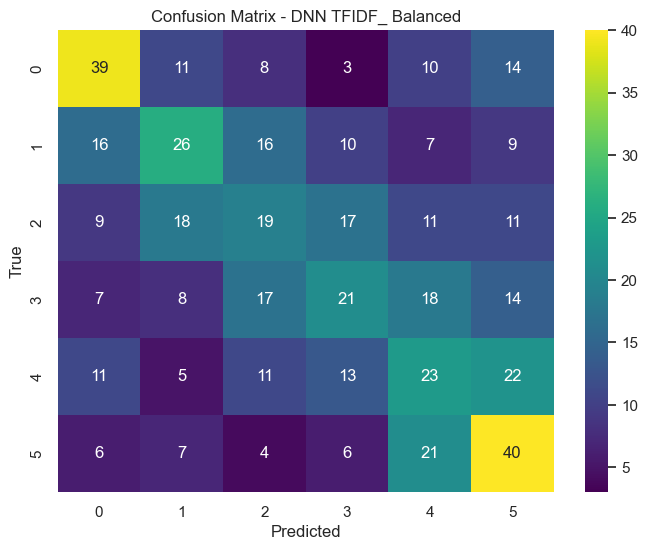

In [122]:
# Generate predictions on the test set for the new model
predicted_labels_tfidf_balanced = np.argmax(test_preds_tfidf_balanced, axis=1)

# Create the confusion matrix for the new model
conf_matrix_tfidf_balanced = confusion_matrix(test_labels_up, predicted_labels_tfidf_balanced)

# Visualize the confusion matrix for the new model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tfidf_balanced, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - DNN TFIDF_ Balanced')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [123]:
pd.DataFrame(classifier_results)

,model,train_f1,val_f1,test_f1
0,RF TF-IDF,0.941,0.226,0.259
1,DNN- GloVe,0.978,NaN,0.247
2,DNN- TF-IDF,0.440,NaN,0.273
3,CNN- GloVe,0.183,NaN,0.154
4,RF TF-IDF Balanced,0.970,0.336,0.969
5,DNN-GloVe_Balanced,0.990,NaN,0.232
6,DNN- TF-IDF_Balanced,0.459,NaN,0.327


In [ ]:
CNN Glove_Balanced 

In [124]:
# Define the model architecture for balanced GloVe embeddings
model_glove_balanced = Sequential([
    Embedding(len(word_index_up) + 1, 100, weights=[glove100_embedding_matrix_up], input_length=length_long_sentence_up, trainable=False),
    Conv1D(128, 3),
    LeakyReLU(),
    MaxPooling1D(3),
    BatchNormalization(),
    Conv1D(128, 3),
    LeakyReLU(),
    MaxPooling1D(3),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [125]:

# Display the model summary
model_glove_balanced.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 7223, 100)         1362100   
                                                                 
 conv1d_2 (Conv1D)           (None, 7221, 128)         38528     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7221, 128)         0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2407, 128)         0         
 g1D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 2407, 128)         512       
 chNormalization)                                                
                                                                 
 conv1d_3 (Conv1D)           (None, 2405, 128)        

In [126]:
# Compile the model
opt = SGD(lr=0.001)
model_glove_balanced.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [127]:
# Train the model on the balanced GloVe embeddings
model_glove_balanced.fit(glove100_train_up, train_labels_up,
                         validation_data=(glove100_val_up, glove_val_labels_up),
                         epochs=15,
                         batch_size=100)

Epoch 1/15
16/16 [==============================] - 27s 2s/step - loss: 5.5867 - accuracy: 0.1984 - val_loss: 1.7886 - val_accuracy: 0.2205
Epoch 2/15
16/16 [==============================] - 27s 2s/step - loss: 1.7526 - accuracy: 0.2319 - val_loss: 1.7872 - val_accuracy: 0.2323
Epoch 3/15
16/16 [==============================] - 27s 2s/step - loss: 1.7202 - accuracy: 0.2503 - val_loss: 1.7846 - val_accuracy: 0.2303
Epoch 4/15
16/16 [==============================] - 27s 2s/step - loss: 1.6914 - accuracy: 0.2792 - val_loss: 1.7797 - val_accuracy: 0.2480
Epoch 5/15
16/16 [==============================] - 27s 2s/step - loss: 1.6505 - accuracy: 0.3081 - val_loss: 1.7793 - val_accuracy: 0.2480
Epoch 6/15
16/16 [==============================] - 27s 2s/step - loss: 1.6351 - accuracy: 0.3193 - val_loss: 1.7780 - val_accuracy: 0.2677
Epoch 7/15
16/16 [==============================] - 27s 2s/step - loss: 1.5828 - accuracy: 0.3226 - val_loss: 1.7707 - val_accuracy: 0.2717
Epoch 8/15
16/16 [==

In [128]:
# Generate train F1 score
train_preds_glove_balanced = model_glove_balanced.predict(glove100_train_up)
train_f1_glove_balanced = f1_score(np.argmax(train_preds_glove_balanced, axis=1),
                                   np.argmax(train_labels_up, axis=1),
                                   average='macro')

# Generate test F1 score
test_preds_glove_balanced = model_glove_balanced.predict(glove100_test_up)
test_f1_glove_balanced = f1_score(np.argmax(test_preds_glove_balanced, axis=1),
                                  test_labels_up,
                                  average='macro')

# Print 
print("Train F1 Score (Balanced GloVe):", train_f1_glove_balanced)
print("Test F1 Score (Balanced GloVe):", test_f1_glove_balanced)

16/16 [==============================] - 3s 158ms/step
Train F1 Score (Balanced GloVe): 0.4532766614463765
Test F1 Score (Balanced GloVe): 0.19508396405989692


In [129]:
# Add the results to classifier_results
data_glove_balanced = {
    'model': 'CNN- GloVe_Balanced',
    'train_f1': round(train_f1_glove_balanced, 3),
    'test_f1': round(test_f1_glove_balanced, 3)
}

classifier_results.append(data_glove_balanced)
data_glove_balanced

{'model': 'CNN- GloVe_Balanced', 'train_f1': 0.453, 'test_f1': 0.195}

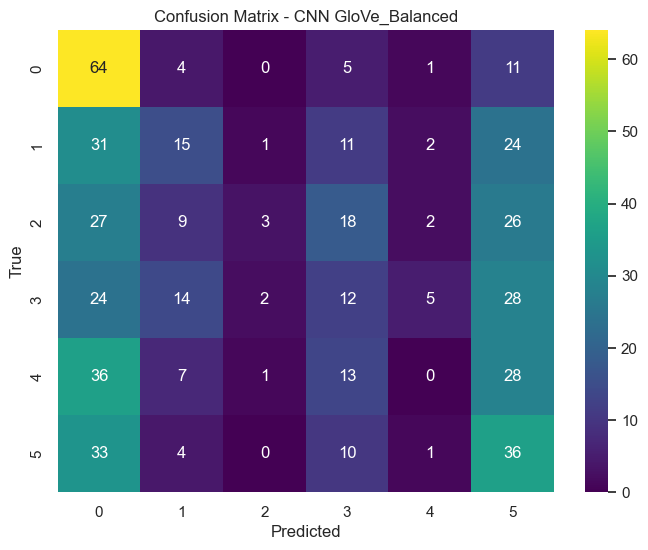

In [133]:
# Create the confusion matrix 
conf_matrix_glove_balanced = confusion_matrix(test_labels_up, predicted_labels_glove_balanced)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_glove_balanced, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - CNN GloVe_Balanced')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [130]:
pd.DataFrame(classifier_results)

,model,train_f1,val_f1,test_f1
0,RF TF-IDF,0.941,0.226,0.259
1,DNN- GloVe,0.978,NaN,0.247
2,DNN- TF-IDF,0.440,NaN,0.273
3,CNN- GloVe,0.183,NaN,0.154
4,RF TF-IDF Balanced,0.970,0.336,0.969
5,DNN-GloVe_Balanced,0.990,NaN,0.232
6,DNN- TF-IDF_Balanced,0.459,NaN,0.327
7,CNN- GloVe_Balanced,0.453,NaN,0.195
